In [ ]:
#pip install torch torchvision sklearn PIL matplotlib pandas numpy --quiet

In [ ]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os
from pathlib import Path
from torchvision import models

In [ ]:
# Making paths configurable

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device available: ", device)

df = pd.read_csv('./All_TIF_labeled_tiles.csv')
root_dir = './CNN_png' 
df['filepath'] = df.apply(
    lambda row: os.path.join(root_dir, str(row['File'])),
    axis=1
)

Device available:  cpu


In [ ]:
# Sanity check for missing files
missing = df[~df['filepath'].apply(os.path.exists)]
if len(missing) > 0:
    print(f"Warning: {len(missing)} files missing!")
    print(missing[['File', 'filepath']].head())

In [ ]:
# Encode Residential/Commmericial class
df['R/C'] = df['R/C'].map({'R': 0, 'C': 1}).fillna(2).astype(int)

# Azimuth class
azimuth_map = {
    'N': 0, 'NE': 1, 'E': 2, 'SE': 3,
    'S': 4, 'SW': 5, 'W': 6, 'NW': 7,
    '0': 8, 0: 8
}

df['Azimuth'] = df['Azimuth'].astype(str).map(azimuth_map)

print("R/C distribution:", df['R/C'].value_counts())
print("Azimuth distribution:", df['Azimuth'].value_counts())
print("Null values in Azimuth:", df['Azimuth'].isna().sum())

R/C distribution: R/C
1    193
0    187
2    172
Name: count, dtype: int64
Azimuth distribution: Azimuth
8    528
4     13
6      5
5      4
2      2
Name: count, dtype: int64
Null values in Azimuth: 0


In [ ]:
# Set seed and split data
SEED = 42
train = df.sample(frac=0.7, random_state=SEED)

test = df.drop(train.index)
val = test.sample(frac=0.5)
test = test.drop(val.index)

print(train.shape)
print(test.shape)
print(val.shape)

(386, 8)
(83, 8)
(83, 8)


In [ ]:
#image size check
sample_img = Image.open(df.iloc[0]['filepath'])
print(f"Original image size: {sample_img.size}")

Original image size: (256, 256)


In [ ]:
# Transform the images 
transform = transforms.Compose([
  transforms.Resize((120, 120)),   
  transforms.ToTensor(),
  transforms.ConvertImageDtype(torch.float32)
])

In [ ]:
# Version 3-Dataset class

class RoofDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        try:
            row = self.df.iloc[idx]
            img = Image.open(row['filepath']).convert("RGB")
            if self.transform:
                img = self.transform(img)

        except Exception as e:
            print(f"Error loading {row['filepath']}: {e}")
            # return a black image or skip
            raise e

        num_roofs  = torch.tensor(row['Num_roofs'], dtype=torch.float32)
        has_roofs  = torch.tensor(row['Has_roofs'], dtype=torch.long)
        rc_class   = torch.tensor(row['R/C'], dtype=torch.long)
        pv_class   = torch.tensor(row['PV'], dtype=torch.long)
        azimuth    = torch.tensor(row['Azimuth'], dtype=torch.long)
        if pd.isna(row['Azimuth']):
            raise ValueError(f"NaN azimuth at index {idx}")

        return img, {
            "num_roofs": num_roofs,      
            "has_roofs": has_roofs,      
            "rc_class": rc_class,        
            "pv_class": pv_class,        
            "azimuth": azimuth           
        }

In [ ]:
train_dataset = RoofDataset(train, transform)
test_dataset = RoofDataset(test, transform)
val_dataset = RoofDataset(val, transform)

In [ ]:
# sanity check
train_dataset.__getitem__(2)

(tensor([[[0.3255, 0.3373, 0.3529,  ..., 0.5490, 0.5451, 0.5451],
          [0.3137, 0.3333, 0.3412,  ..., 0.5569, 0.5529, 0.5490],
          [0.3176, 0.3255, 0.3294,  ..., 0.5686, 0.5647, 0.5529],
          ...,
          [0.2902, 0.2824, 0.2824,  ..., 0.5725, 0.5804, 0.5804],
          [0.2941, 0.2863, 0.2863,  ..., 0.5804, 0.5843, 0.5765],
          [0.2941, 0.2902, 0.2902,  ..., 0.5922, 0.5922, 0.5882]],
 
         [[0.3176, 0.3373, 0.3451,  ..., 0.5294, 0.5255, 0.5333],
          [0.3059, 0.3255, 0.3373,  ..., 0.5373, 0.5333, 0.5333],
          [0.3137, 0.3176, 0.3255,  ..., 0.5451, 0.5490, 0.5373],
          ...,
          [0.3020, 0.2941, 0.2941,  ..., 0.5647, 0.5686, 0.5647],
          [0.3059, 0.2980, 0.2980,  ..., 0.5686, 0.5725, 0.5608],
          [0.3059, 0.3020, 0.3020,  ..., 0.5804, 0.5765, 0.5725]],
 
         [[0.3137, 0.3255, 0.3373,  ..., 0.4980, 0.4941, 0.5020],
          [0.3020, 0.3176, 0.3333,  ..., 0.5098, 0.5020, 0.5059],
          [0.3098, 0.3176, 0.3216,  ...,

In [ ]:
# Parameters 
lr = 1e-4        
batch_size = 32  
epochs = 32      

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Multi-head model with CNN backbone
# 5 heads:
# - one regression head
# - four classification heads

class MultiOutputCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # backbone
        self.base = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        in_feats = self.base.fc.in_features
        self.base.fc = nn.Identity()
        
        # heads
        self.num_roofs = nn.Linear(in_feats, 1)      
        self.has_roofs = nn.Linear(in_feats, 2)      
        self.rc_class  = nn.Linear(in_feats, 3)      
        self.pv_class  = nn.Linear(in_feats, 2)      
        self.azimuth   = nn.Linear(in_feats, 9)      
    
    def forward(self, x):
        feats = self.base(x)
        
        return {
            "num_roofs": self.num_roofs(feats),
            "has_roofs": self.has_roofs(feats),
            "rc_class": self.rc_class(feats),
            "pv_class": self.pv_class(feats),
            "azimuth": self.azimuth(feats)
        }

model = MultiOutputCNN().to(device)

# Loss functions
criterion_mse = nn.MSELoss()
criterion_ce = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)

# Loss weights
loss_weights = {
    'num_roofs': 1.0,
    'has_roofs': 1.0,
    'rc_class': 1.0,
    'pv_class': 1.0,
    'azimuth': 1.0
}

# Training history
history = {
    'train_loss': [], 'val_loss': [],
    'train_acc_has': [], 'val_acc_has': [],
    'train_acc_rc': [], 'val_acc_rc': [],
    'train_acc_pv': [], 'val_acc_pv': [],
    'train_acc_az': [], 'val_acc_az': []
}

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss_train = 0
    correct_has, correct_rc, correct_pv, correct_az = 0, 0, 0, 0
    total_samples = 0
    
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        
        labels_device = {k: v.to(device) for k, v in labels.items()}
        
        outputs = model(imgs)
        
        loss_num = criterion_mse(outputs["num_roofs"].squeeze(), labels_device["num_roofs"])
        loss_has = criterion_ce(outputs["has_roofs"], labels_device["has_roofs"])
        loss_rc = criterion_ce(outputs["rc_class"], labels_device["rc_class"])
        loss_pv = criterion_ce(outputs["pv_class"], labels_device["pv_class"])
        loss_az = criterion_ce(outputs["azimuth"], labels_device["azimuth"])
        
        # weighted losses
        loss = (loss_weights['num_roofs'] * loss_num +
                loss_weights['has_roofs'] * loss_has +
                loss_weights['rc_class'] * loss_rc +
                loss_weights['pv_class'] * loss_pv +
                loss_weights['azimuth'] * loss_az)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # metrics
        total_loss_train += loss.item() * imgs.size(0)
        batch_size = imgs.size(0)
        total_samples += batch_size
        
        # accuracies
        correct_has += (outputs["has_roofs"].argmax(1) == labels_device["has_roofs"]).sum().item()
        correct_rc += (outputs["rc_class"].argmax(1) == labels_device["rc_class"]).sum().item()
        correct_pv += (outputs["pv_class"].argmax(1) == labels_device["pv_class"]).sum().item()
        correct_az += (outputs["azimuth"].argmax(1) == labels_device["azimuth"]).sum().item()
    
    # avg training metrics
    avg_train_loss = total_loss_train / total_samples
    acc_has_train = 100 * correct_has / total_samples
    acc_rc_train = 100 * correct_rc / total_samples
    acc_pv_train = 100 * correct_pv / total_samples
    acc_az_train = 100 * correct_az / total_samples
    
    # Validation
    model.eval()
    total_loss_val = 0
    correct_has_val, correct_rc_val, correct_pv_val, correct_az_val = 0, 0, 0, 0
    total_samples_val = 0
    
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            labels_device = {k: v.to(device) for k, v in labels.items()}
            
            outputs = model(imgs)
            
            loss_num = criterion_mse(outputs["num_roofs"].squeeze(), labels_device["num_roofs"])
            loss_has = criterion_ce(outputs["has_roofs"], labels_device["has_roofs"])
            loss_rc = criterion_ce(outputs["rc_class"], labels_device["rc_class"])
            loss_pv = criterion_ce(outputs["pv_class"], labels_device["pv_class"])
            loss_az = criterion_ce(outputs["azimuth"], labels_device["azimuth"])
            
            loss = (loss_weights['num_roofs'] * loss_num +
                    loss_weights['has_roofs'] * loss_has +
                    loss_weights['rc_class'] * loss_rc +
                    loss_weights['pv_class'] * loss_pv +
                    loss_weights['azimuth'] * loss_az)
            
            # metrics
            batch_size = imgs.size(0)
            total_loss_val += loss.item() * batch_size
            total_samples_val += batch_size
            
            # accuracies
            correct_has_val += (outputs["has_roofs"].argmax(1) == labels_device["has_roofs"]).sum().item()
            correct_rc_val += (outputs["rc_class"].argmax(1) == labels_device["rc_class"]).sum().item()
            correct_pv_val += (outputs["pv_class"].argmax(1) == labels_device["pv_class"]).sum().item()
            correct_az_val += (outputs["azimuth"].argmax(1) == labels_device["azimuth"]).sum().item()
    
    # avg validation metrics
    avg_val_loss = total_loss_val / total_samples_val
    acc_has_val = 100 * correct_has_val / total_samples_val
    acc_rc_val = 100 * correct_rc_val / total_samples_val
    acc_pv_val = 100 * correct_pv_val / total_samples_val
    acc_az_val = 100 * correct_az_val / total_samples_val
    
    # history
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['train_acc_has'].append(acc_has_train)
    history['val_acc_has'].append(acc_has_val)
    history['train_acc_rc'].append(acc_rc_train)
    history['val_acc_rc'].append(acc_rc_val)
    history['train_acc_pv'].append(acc_pv_train)
    history['val_acc_pv'].append(acc_pv_val)
    history['train_acc_az'].append(acc_az_train)
    history['val_acc_az'].append(acc_az_val)
    
    # results
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"  Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print(f"  Has_Roofs - Train: {acc_has_train:.2f}% | Val: {acc_has_val:.2f}%")
    print(f"  R/C Class - Train: {acc_rc_train:.2f}% | Val: {acc_rc_val:.2f}%")
    print(f"  PV Class  - Train: {acc_pv_train:.2f}% | Val: {acc_pv_val:.2f}%")
    print(f"  Azimuth   - Train: {acc_az_train:.2f}% | Val: {acc_az_val:.2f}%")
    print()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Owner/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:04<00:00, 10.2MB/s]


Epoch 1/16
  Train Loss: 6.4262 | Val Loss: 6.0378
  Has_Roofs - Train: 72.54% | Val: 84.34%
  R/C Class - Train: 48.45% | Val: 71.08%
  PV Class  - Train: 61.40% | Val: 90.36%
  Azimuth   - Train: 56.99% | Val: 86.75%

Epoch 2/16
  Train Loss: 2.2286 | Val Loss: 2.7740
  Has_Roofs - Train: 96.63% | Val: 89.16%
  R/C Class - Train: 91.45% | Val: 75.90%
  PV Class  - Train: 92.23% | Val: 89.16%
  Azimuth   - Train: 95.85% | Val: 95.18%

Epoch 3/16
  Train Loss: 1.5358 | Val Loss: 2.5307
  Has_Roofs - Train: 94.82% | Val: 86.75%
  R/C Class - Train: 92.49% | Val: 83.13%
  PV Class  - Train: 93.78% | Val: 91.57%
  Azimuth   - Train: 96.11% | Val: 95.18%

Epoch 4/16
  Train Loss: 0.9120 | Val Loss: 2.2820
  Has_Roofs - Train: 99.48% | Val: 86.75%
  R/C Class - Train: 98.45% | Val: 84.34%
  PV Class  - Train: 96.11% | Val: 91.57%
  Azimuth   - Train: 96.37% | Val: 95.18%

Epoch 5/16
  Train Loss: 0.6877 | Val Loss: 2.3706
  Has_Roofs - Train: 99.48% | Val: 85.54%
  R/C Class - Train: 98.96%

In [ ]:
from sklearn.metrics import f1_score
# Testing
model.eval()
test_metrics = {
    'loss': 0, 'correct_has': 0, 'correct_rc': 0,
    'correct_pv': 0, 'correct_az': 0, 'mse_num': 0
}

all_preds = { 'has_roofs': [], 'rc_class': [], 'pv_class': [], 'azimuth': [] }
all_labels = { 'has_roofs': [], 'rc_class': [], 'pv_class': [], 'azimuth': [] }

total_test = 0

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels_device = {k: v.to(device) for k, v in labels.items()}
        
        outputs = model(imgs)

        batch_size = imgs.size(0)
        total_test += batch_size
        
        # accuracies
        test_metrics['correct_has'] += (outputs["has_roofs"].argmax(1) == labels_device["has_roofs"]).sum().item()
        test_metrics['correct_rc'] += (outputs["rc_class"].argmax(1) == labels_device["rc_class"]).sum().item()
        test_metrics['correct_pv'] += (outputs["pv_class"].argmax(1) == labels_device["pv_class"]).sum().item()
        test_metrics['correct_az'] += (outputs["azimuth"].argmax(1) == labels_device["azimuth"]).sum().item()

        for key in all_preds.keys():
            all_preds[key].extend(outputs[key].argmax(1).cpu().numpy())
            all_labels[key].extend(labels_device[key].cpu().numpy())
        
        # MSE for regression
        mse = ((outputs["num_roofs"].squeeze() - labels_device["num_roofs"])**2).sum().item()
        test_metrics['mse_num'] += mse

f1_has = f1_score(all_labels['has_roofs'], all_preds['has_roofs'], average='binary')
f1_rc  = f1_score(all_labels['rc_class'],   all_preds['rc_class'],   average='macro')
f1_pv  = f1_score(all_labels['pv_class'],   all_preds['pv_class'],   average='macro')
f1_az  = f1_score(all_labels['azimuth'],    all_preds['azimuth'],    average='macro')

print("\n=== TEST RESULTS ===")
print(f"Has Roofs Accuracy: {100 * test_metrics['correct_has'] / total_test:.2f}%")
print(f"R/C Class Accuracy: {100 * test_metrics['correct_rc'] / total_test:.2f}%")
print(f"PV Class Accuracy: {100 * test_metrics['correct_pv'] / total_test:.2f}%")
print(f"Azimuth Accuracy: {100 * test_metrics['correct_az'] / total_test:.2f}%")
print(f"Num Roofs MSE: {test_metrics['mse_num'] / total_test:.4f}")

# F1 scores
print("\n--- F1 SCORES ---")
print(f"Has Roofs F1: {f1_has:.4f}")
print(f"R/C Class F1: {f1_rc:.4f}")
print(f"PV Class F1: {f1_pv:.4f}")
print(f"Azimuth F1:  {f1_az:.4f}")


=== TEST RESULTS ===
Has Roofs Accuracy: 89.16%
R/C Class Accuracy: 83.13%
PV Class Accuracy: 91.57%
Azimuth Accuracy: 93.98%
Num Roofs MSE: 0.8467

--- F1 SCORES ---
Has Roofs F1: 0.9268
R/C Class F1: 0.8274
PV Class F1: 0.7079
Azimuth F1:  0.1938


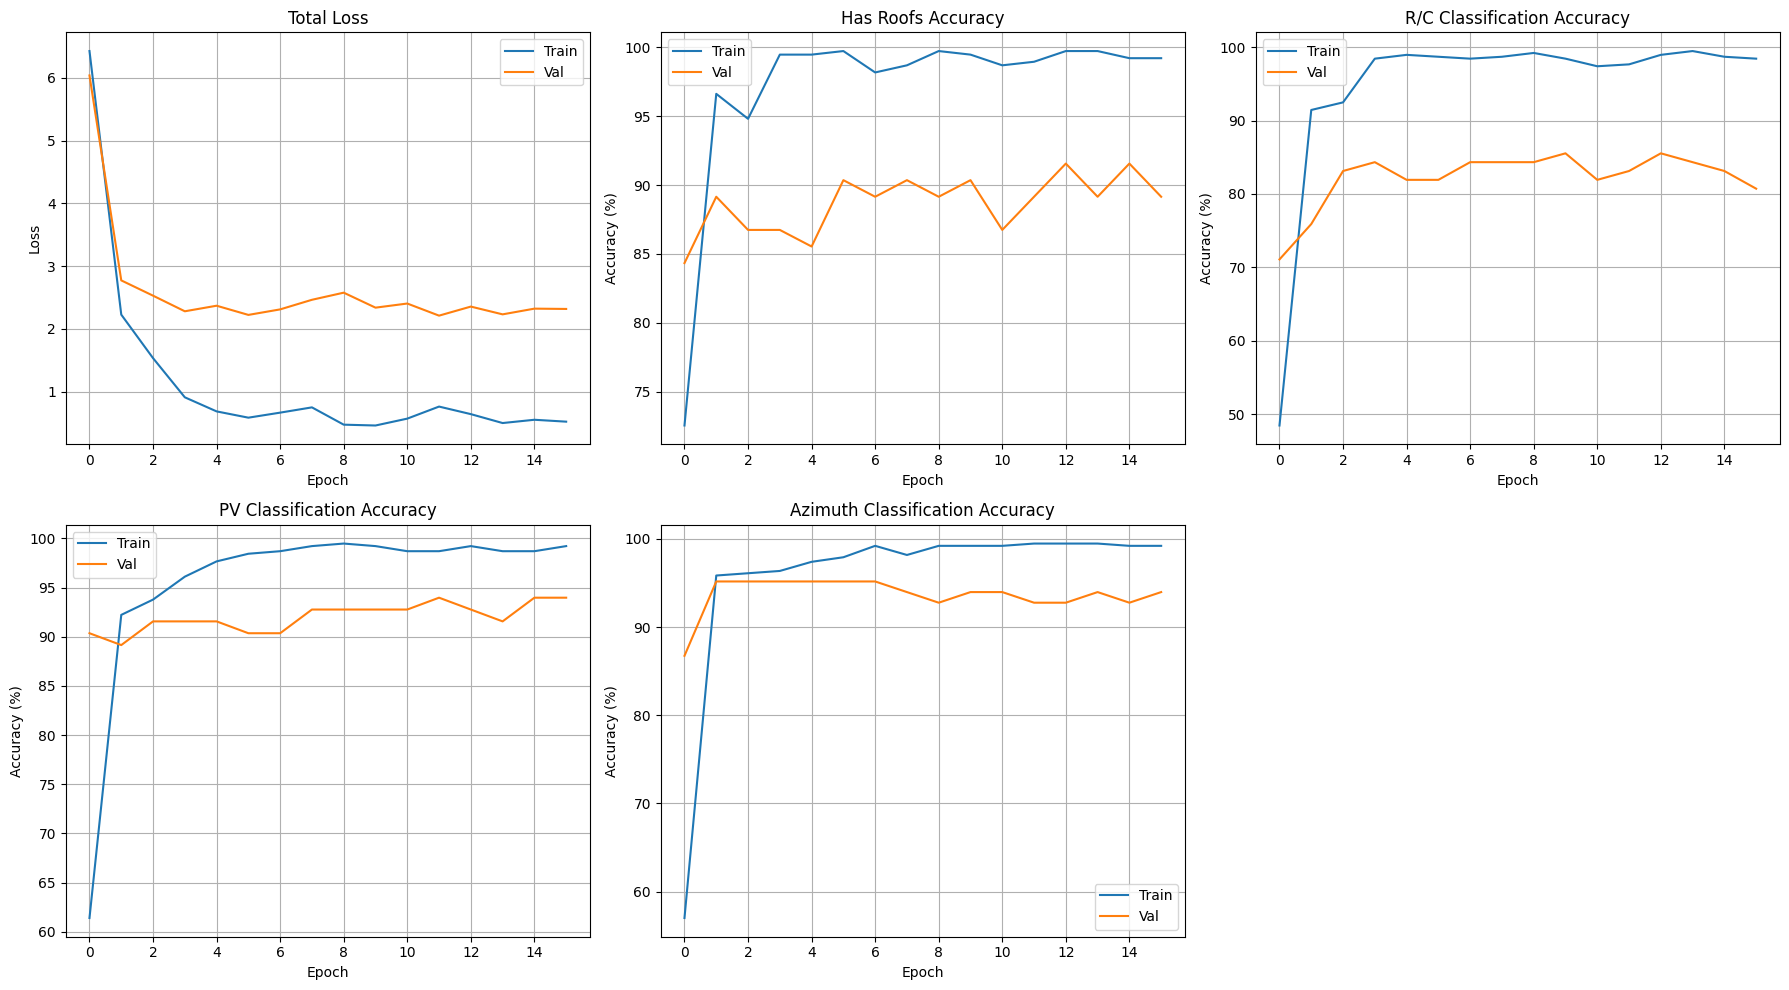

In [ ]:
# Plot 
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Losses
axes[0, 0].plot(history['train_loss'], label='Train')
axes[0, 0].plot(history['val_loss'], label='Val')
axes[0, 0].set_title('Total Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Has Roofs Accuracy
axes[0, 1].plot(history['train_acc_has'], label='Train')
axes[0, 1].plot(history['val_acc_has'], label='Val')
axes[0, 1].set_title('Has Roofs Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].legend()
axes[0, 1].grid(True)

# R/C Accuracy
axes[0, 2].plot(history['train_acc_rc'], label='Train')
axes[0, 2].plot(history['val_acc_rc'], label='Val')
axes[0, 2].set_title('R/C Classification Accuracy')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Accuracy (%)')
axes[0, 2].legend()
axes[0, 2].grid(True)

# PV Accuracy
axes[1, 0].plot(history['train_acc_pv'], label='Train')
axes[1, 0].plot(history['val_acc_pv'], label='Val')
axes[1, 0].set_title('PV Classification Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy (%)')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Azimuth Accuracy
axes[1, 1].plot(history['train_acc_az'], label='Train')
axes[1, 1].plot(history['val_acc_az'], label='Val')
axes[1, 1].set_title('Azimuth Classification Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Hide the unused subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()